# Benchmark: Regressão Logística

Neste notebook vamos aplicar um modelo de Regressão Logística para servir de baseline.
Este modelo é mais simples e interpretável, servindo de ponto de comparação para o XGBoost.

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar Dataset
df = pd.read_csv('../Datasets/dataset_final_merged_v2.csv', low_memory=False)

# Converter Data
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values('Data')

# Criar Target
mapping_resultado = {'H': 0, 'D': 1, 'A': 2}
df['Target'] = df['Resultado_Final'].map(mapping_resultado)
df = df.dropna(subset=['Target'])

In [7]:
# Seleção de Features (Mesmas do XGBoost)
features = [
#     'Odd_Casa_Bet365', 'Odd_Empate_Bet365', 'Odd_Visitante_Bet365',
    'Home_hist_Pontos', 'Home_hist_GolosMarcados', 'Home_hist_GolosSofridos', 
    'Home_hist_xG', 'Home_hist_xGA', 'Home_hist_PosseDeBola',
    'Away_hist_Pontos', 'Away_hist_GolosMarcados', 'Away_hist_GolosSofridos',
    'Away_hist_xG', 'Away_hist_xGA', 'Away_hist_PosseDeBola',
    # Stats Forma (5 jogos)
    'Casa_Form_Pts5', 'Casa_Form_GM5', 'Casa_Form_GS5',
    'Visitante_Form_Pts5', 'Visitante_Form_GM5', 'Visitante_Form_GS5',
    'Casa_Form_Empates5',
    'Visitante_Form_Empates5',
    'Home_hist_GolosEsperados',
    'Home_hist_GolosEsperadosSofridos',
    'Away_hist_GolosEsperados',
    'Away_hist_GolosEsperadosSofridos',
    'Home_hist_PassesProgressivos',
    'Away_hist_PassesProgressivos',
    'Home_hist_JogosSemSofrerGolos',
    'Away_hist_JogosSemSofrerGolos'
]

features_existentes = [c for c in features if c in df.columns]
X = df[features_existentes]
y = df['Target']

In [8]:
# Divisão Treino / Teste (Temporal)
split_date = '2023-08-01'
mask_train = df['Data'] < split_date
mask_test = df['Data'] >= split_date

X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[mask_test]
y_test = y[mask_test]

# Scaling & Imputation (Importante para LogReg)
# Regressão Logística falha com NaNs e beneficia de dados normalizados
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Pipeline manual: Impute -> Scale
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Treino: {len(X_train)} jogos")
print(f"Teste: {len(X_test)} jogos")

Treino: 3714 jogos
Teste: 711 jogos


In [9]:
# Treinar Regressão Logística
# multi_class='multinomial' para lidar com 3 classes (H, D, A)
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

Accuracy (LogReg): 0.51

Classification Report:
              precision    recall  f1-score   support

        Casa       0.64      0.56      0.60       300
      Empate       0.30      0.38      0.34       180
   Visitante       0.56      0.54      0.55       231

    accuracy                           0.51       711
   macro avg       0.50      0.49      0.49       711
weighted avg       0.53      0.51      0.51       711



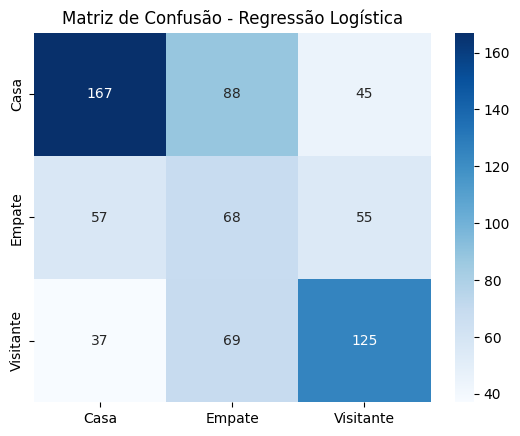

In [10]:
# Avaliação
y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (LogReg): {acc:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Casa', 'Empate', 'Visitante']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Casa', 'Empate', 'Visitante'], yticklabels=['Casa', 'Empate', 'Visitante'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()